# 07 — Model Evaluation Metrics

Accuracy alone is misleading. A model can have high accuracy and still perform poorly, especially with class imbalance.

This notebook covers:
- Confusion Matrix
- Precision and Recall
- F1 Score
- ROC Curve and AUC
- When to choose which metric


Step 1 — Reload the Preprocessed Setup (Same Titanic Workflow)

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df = df.drop(columns=["Cabin", "Ticket", "Name", "PassengerId"])

X = df.drop(columns=["Survived"])
y = df["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


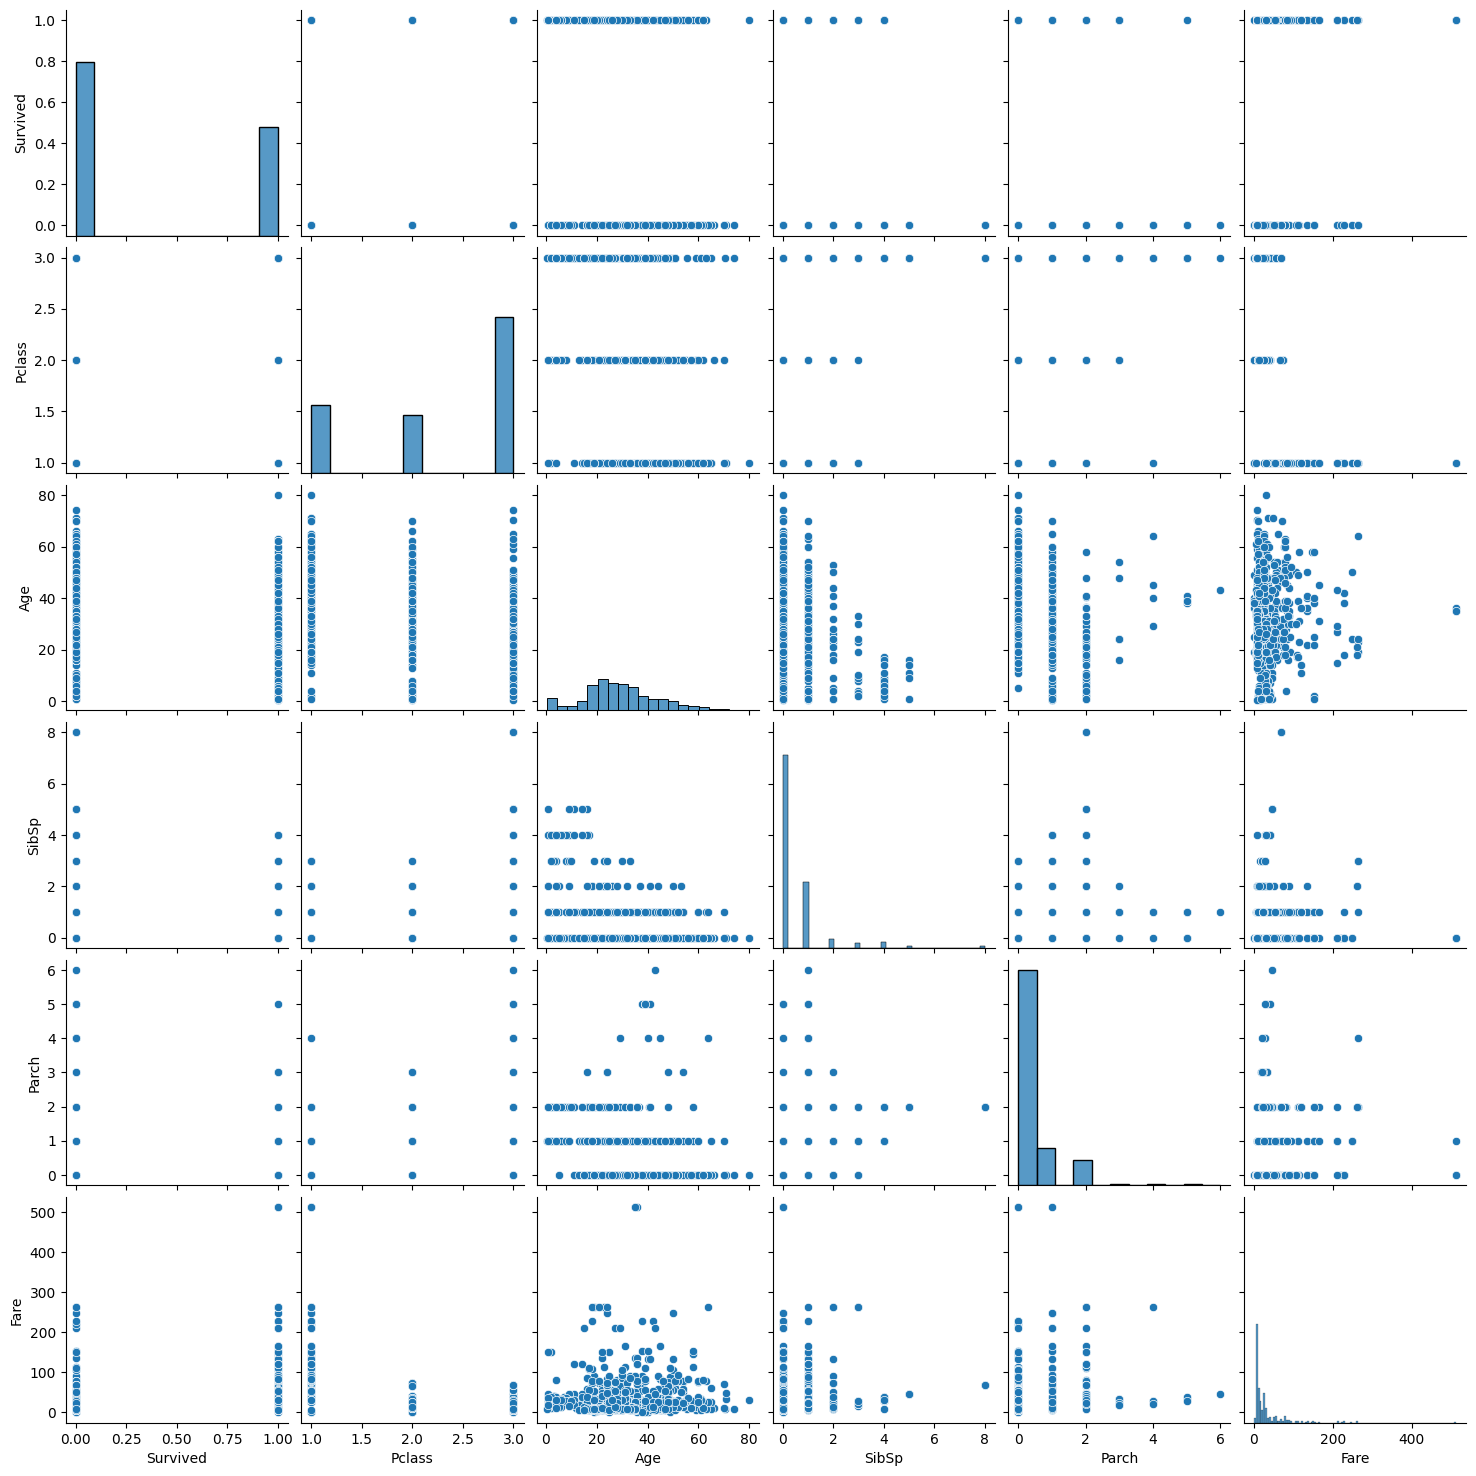

In [2]:
import seaborn as sns
sns.pairplot(df)

Step 2 — Build Preprocessing Pipeline

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [4]:
preprocessor 

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


Step 3 — Train a Single Model (Logistic Regression for clarity)

In [5]:
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Step 4 — Compute Core Evaluation Metrics

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))


Accuracy : 0.8044692737430168
Precision: 0.7931034482758621
Recall   : 0.6666666666666666
F1 Score : 0.7244094488188977


Step 5 — Confusion Matrix (Must Visualize)

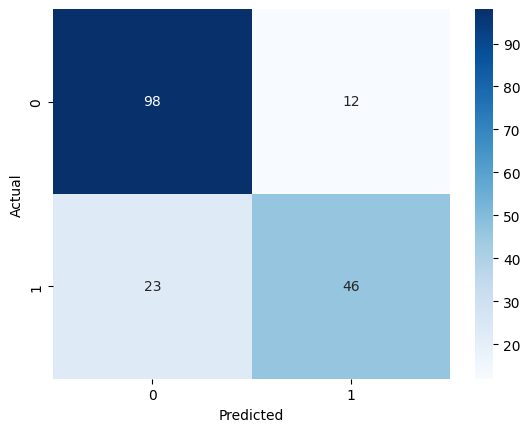

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Interpretation (You must internalize this):
| Metric | Meaning                                                          |
| ------ | ---------------------------------------------------------------- |
| TP     | Correctly predicted survivors                                    |
| TN     | Correctly predicted non-survivors                                |
| FP     | Predicted survived but actually died                             |
| FN     | Predicted died but actually survived (**this one kills recall**) |


Step 6 — ROC-AUC Score

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve

y_probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)
auc


0.8437417654808959

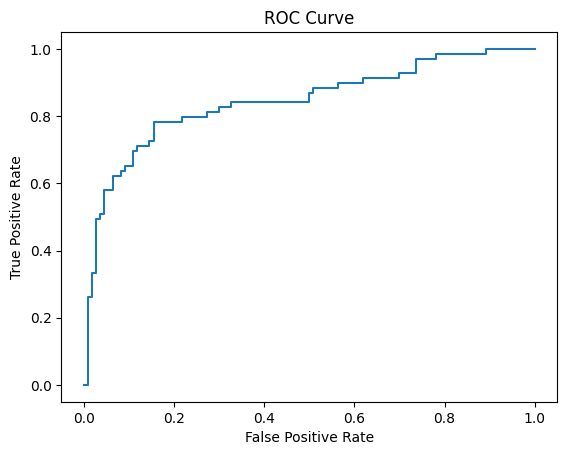

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


Key Understanding:

Accuracy answers: “How many predictions did I get right?”

Precision answers: “When I predicted survival, how often was I correct?”

Recall answers: “Among actual survivors, how many did I catch?”

F1 balances precision and recall.

AUC measures how well the model ranks probabilities.

Now pay attention — this is where most people misinterpret results.
You are not supposed to say:

“Accuracy is good so model is good”

Because based on your numbers:

Recall is weak.

Meaning:
The model is missing actual survivors.

In survival prediction context, recall matters more than accuracy.

Example:

If your model predicts many people as “dead” when they actually survived, you failed the real problem.

This is why we don’t trust accuracy.
Now you understand evaluation correctly.